In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
# Step 1: Load the dataset
dataset = pd.read_csv('/content/drive/My Drive/telematics_syn.csv')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Create the adjusted ClaimYN label
dataset['ClaimYN'] = ((dataset['NB_Claim'] >= 1) & (dataset['AMT_Claim'] > 1000)).astype(int)

# Preprocess the dataset
# 1. Handle missing values
dataset.fillna(method='ffill', inplace=True)  # Simple forward fill for missing values

# 2. Encode categorical variables (if any exist)
categorical_columns = dataset.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])

# 3. Standardize numerical columns
numerical_columns = dataset.drop(columns=['ClaimYN', 'NB_Claim', 'AMT_Claim']).columns
scaler = StandardScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

# Handle the imbalance in the dataset using SMOTE
X = dataset.drop(columns=['ClaimYN'])
y = dataset['ClaimYN']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Merging resampled data back into a single DataFrame
dataset_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Drop NB_Claim and AMT_Claim columns
dataset_resampled = dataset_resampled.drop(columns=['NB_Claim', 'AMT_Claim'])

# Split the dataset into train, test, and validation sets
from sklearn.model_selection import train_test_split

X = dataset_resampled.drop(columns=['ClaimYN'])
y = dataset_resampled['ClaimYN']

# Split the data (70% train, 15% test, 15% validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 136222
Testing set size: 29191
Validation set size: 29191


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=200)
log_reg.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     14593
           1       0.74      0.80      0.77     14598

    accuracy                           0.76     29191
   macro avg       0.76      0.76      0.76     29191
weighted avg       0.76      0.76      0.76     29191



In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14593
           1       1.00      0.98      0.99     14598

    accuracy                           0.99     29191
   macro avg       0.99      0.99      0.99     29191
weighted avg       0.99      0.99      0.99     29191



In [7]:
from xgboost import XGBClassifier

# Initialize and train the XGBoost model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14593
           1       1.00      0.98      0.99     14598

    accuracy                           0.99     29191
   macro avg       0.99      0.99      0.99     29191
weighted avg       0.99      0.99      0.99     29191



In [8]:
!pip install pytorch_tabnet

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [9]:
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np

# Convert data to numpy arrays for TabNet
X_train_np, y_train_np = X_train.values, y_train.values
X_test_np, y_test_np = X_test.values, y_test.values

# Initialize and train the TabNet model
tabnet = TabNetClassifier(seed=42)
tabnet.fit(X_train_np, y_train_np, eval_set=[(X_test_np, y_test_np)], patience=10)

# Evaluate the model on the test set
y_pred = np.argmax(tabnet.predict_proba(X_test_np), axis=1)
print("TabNet Classification Report:")
print(classification_report(y_test_np, y_pred))

epoch 0  | loss: 0.52504 | val_0_auc: 0.88173 |  0:00:23s
epoch 1  | loss: 0.40063 | val_0_auc: 0.91582 |  0:00:36s
epoch 2  | loss: 0.36553 | val_0_auc: 0.92501 |  0:00:44s
epoch 3  | loss: 0.33912 | val_0_auc: 0.84918 |  0:00:53s
epoch 4  | loss: 0.32147 | val_0_auc: 0.93409 |  0:01:01s
epoch 5  | loss: 0.30906 | val_0_auc: 0.87753 |  0:01:10s
epoch 6  | loss: 0.29658 | val_0_auc: 0.82212 |  0:01:19s
epoch 7  | loss: 0.28286 | val_0_auc: 0.85643 |  0:01:27s
epoch 8  | loss: 0.28663 | val_0_auc: 0.9294  |  0:01:38s
epoch 9  | loss: 0.28628 | val_0_auc: 0.92491 |  0:01:46s
epoch 10 | loss: 0.27638 | val_0_auc: 0.93338 |  0:01:55s
epoch 11 | loss: 0.26571 | val_0_auc: 0.95694 |  0:02:04s
epoch 12 | loss: 0.25292 | val_0_auc: 0.87831 |  0:02:12s
epoch 13 | loss: 0.2587  | val_0_auc: 0.95842 |  0:02:21s
epoch 14 | loss: 0.24295 | val_0_auc: 0.96465 |  0:02:29s
epoch 15 | loss: 0.2294  | val_0_auc: 0.97015 |  0:02:38s
epoch 16 | loss: 0.22512 | val_0_auc: 0.91345 |  0:02:47s
epoch 17 | los

In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam

# Reshape data for RNN (3D input: samples, timesteps, features)
X_train_rnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_rnn = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_rnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Initialize the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(32, input_shape=(X_train_rnn.shape[1], 1), activation='relu'))
rnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = rnn_model.evaluate(X_test_rnn, y_test)
print(f"RNN Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - accuracy: 0.7375 - loss: 0.5303 - val_accuracy: 0.7629 - val_loss: 0.5230
Epoch 2/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - accuracy: 0.7849 - loss: 0.4610 - val_accuracy: 0.7766 - val_loss: 0.4612
Epoch 3/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.7808 - loss: 0.4568 - val_accuracy: 0.7796 - val_loss: 0.4521
Epoch 4/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.8002 - loss: 0.4287 - val_accuracy: 0.7612 - val_loss: 0.5255
Epoch 5/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.8106 - loss: 0.4080 - val_accuracy: 0.8318 - val_loss: 0.3717
Epoch 6/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.8258 - loss: 0.3837 - val_accuracy: 0.8402 - val_loss: 0.3483
Epoch 7/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.8145 - loss: 0.4069 - val_accuracy: 0.8482 - val_loss: 0.3447
Epoch 8/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.8139 - loss: 

In [11]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

# Initialize the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_rnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_history = cnn_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test_rnn, y_test)
print(f"CNN Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8093 - loss: 0.4233 - val_accuracy: 0.8564 - val_loss: 0.3272
Epoch 2/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8583 - loss: 0.3220 - val_accuracy: 0.8582 - val_loss: 0.3148
Epoch 3/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8652 - loss: 0.3056 - val_accuracy: 0.8702 - val_loss: 0.2966
Epoch 4/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8711 - loss: 0.2939 - val_accuracy: 0.8759 - val_loss: 0.2867
Epoch 5/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8764 - loss: 0.2823 - val_accuracy: 0.8776 - val_loss: 0.2829
Epoch 6/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8825 - loss: 0.2708 - val_accuracy: 0.8818 - val_loss: 0.2724
Epoch 7/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8876 - loss: 0.2614 - val_accuracy: 0.8872 - val_loss: 0.2585
Epoch 8/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8884 - loss: 0

In [12]:
from keras.layers import LSTM

# Initialize the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(X_train_rnn.shape[1], 1), activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32,
                              validation_data=(X_val_rnn, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = lstm_model.evaluate(X_test_rnn, y_test)
print(f"LSTM Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.7088 - loss: 0.5864 - val_accuracy: 0.7875 - val_loss: 0.4520
Epoch 2/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 77s 18ms/step - accuracy: 0.7919 - loss: 0.4452 - val_accuracy: 0.8190 - val_loss: 0.3907
Epoch 3/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.8170 - loss: 0.3949 - val_accuracy: 0.8278 - val_loss: 0.3678
Epoch 4/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.8124 - loss: 4077.3645 - val_accuracy: 0.7650 - val_loss: 0.4975
Epoch 5/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.7718 - loss: 0.4897 - val_accuracy: 0.7663 - val_loss: 0.4904
Epoch 6/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.7721 - loss: 0.4857 - val_accuracy: 0.7797 - val_loss: 0.4716
Epoch 7/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.7843 - loss: 0.4650 - val_accuracy: 0.7872 - val_loss: 0.4534
Epoch 8/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 76s 18ms/step - accuracy: 0.780

In [13]:
from keras.layers import GRU

# Initialize the GRU model
gru_model = Sequential()
gru_model.add(GRU(32, input_shape=(X_train_rnn.shape[1], 1), activation='relu'))
gru_model.add(Dense(1, activation='sigmoid'))

# Compile the model
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
gru_history = gru_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = gru_model.evaluate(X_test_rnn, y_test)
print(f"GRU Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 101s 23ms/step - accuracy: 0.7216 - loss: 0.5354 - val_accuracy: 0.8000 - val_loss: 0.4257
Epoch 2/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 144s 23ms/step - accuracy: 0.8111 - loss: 0.4068 - val_accuracy: 0.8491 - val_loss: 0.3242
Epoch 3/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 143s 24ms/step - accuracy: 0.8554 - loss: 0.3102 - val_accuracy: 0.8677 - val_loss: 0.2812
Epoch 4/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 141s 23ms/step - accuracy: 0.8804 - loss: 0.2603 - val_accuracy: 0.8923 - val_loss: 0.2420
Epoch 5/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 100s 24ms/step - accuracy: 0.8797 - loss: 0.2685 - val_accuracy: 0.8978 - val_loss: 0.2300
Epoch 6/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 101s 24ms/step - accuracy: 0.8888 - loss: 0.2493 - val_accuracy: 0.8941 - val_loss: 0.2327
Epoch 7/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 99s 23ms/step - accuracy: 0.8937 - loss: 0.2409 - val_accuracy: 0.8905 - val_loss: 0.2407
Epoch 8/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 100s 23ms/step - accuracy: 0

## Import Necessary Libraries for Evaluation

In [14]:
from sklearn.metrics import matthews_corrcoef, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure you have seaborn for nicer plots
sns.set(style="whitegrid")

In [15]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Evaluate the model using MCC, AUC, and plot the confusion matrix."""

    # Calculate MCC
    mcc = matthews_corrcoef(y_true, y_pred)

    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred_proba)

    # Print results
    print(f"{model_name} Evaluation:")
    print(f"  MCC: {mcc:.4f}")
    print(f"  AUC: {auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

def plot_training_history(history, model_name):
    """Plot training & validation accuracy and loss from the model's history."""
    # Accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Logistic Regression Evaluation:
  MCC: 0.5273
  AUC: 0.8307


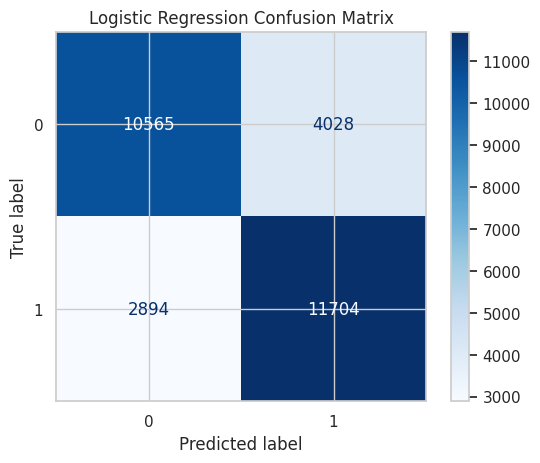

In [16]:
# Predict probabilities for AUC calculation
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the Logistic Regression model
evaluate_model(y_test, y_pred_log_reg, y_pred_proba_log_reg, "Logistic Regression")

Random Forest Evaluation:
  MCC: 0.9810
  AUC: 0.9987


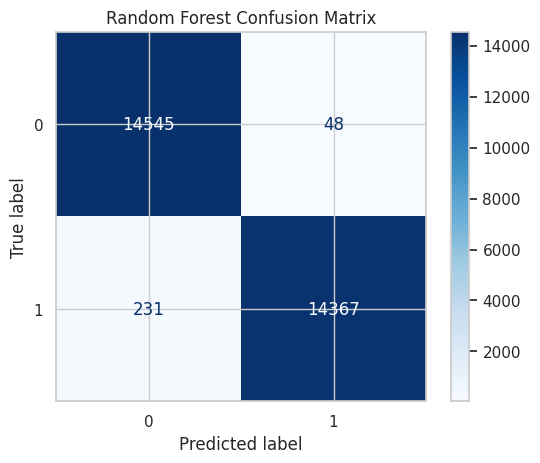

In [17]:
# Predict probabilities for AUC calculation
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

# Evaluate the Random Forest model
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest")

XGBoost Evaluation:
  MCC: 0.9771
  AUC: 0.9979


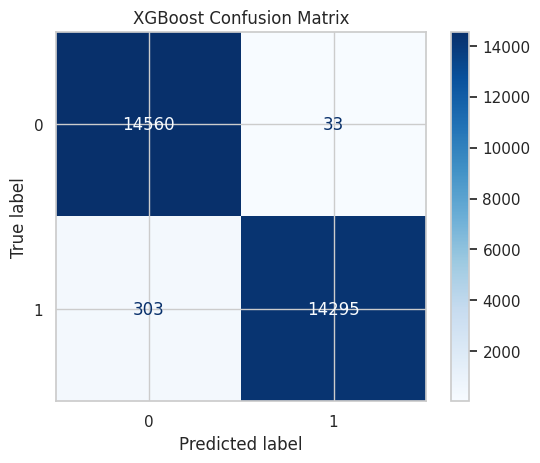

In [18]:
# Predict probabilities for AUC calculation
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb.predict(X_test)

# Evaluate the XGBoost model
evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost")

TabNet Evaluation:
  MCC: 0.8254
  AUC: 0.9753


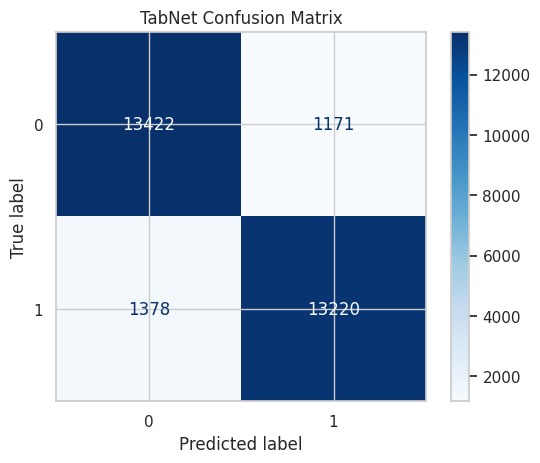

In [19]:
# Predict probabilities for AUC calculation
y_pred_proba_tabnet = tabnet.predict_proba(X_test_np)[:, 1]
y_pred_tabnet = np.argmax(tabnet.predict_proba(X_test_np), axis=1)

# Evaluate the TabNet model
evaluate_model(y_test_np, y_pred_tabnet, y_pred_proba_tabnet, "TabNet")

913/913 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
RNN Evaluation:
  MCC: 0.8030
  AUC: 0.9669


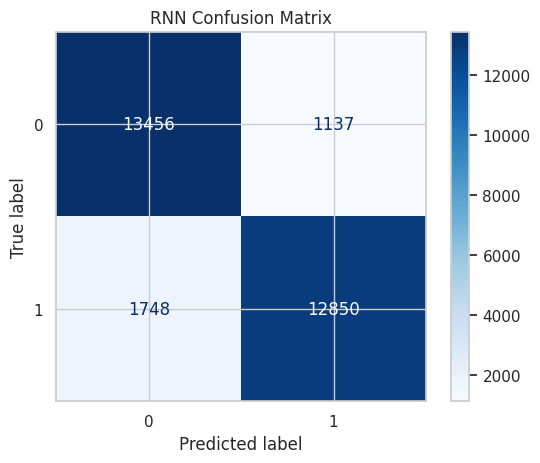

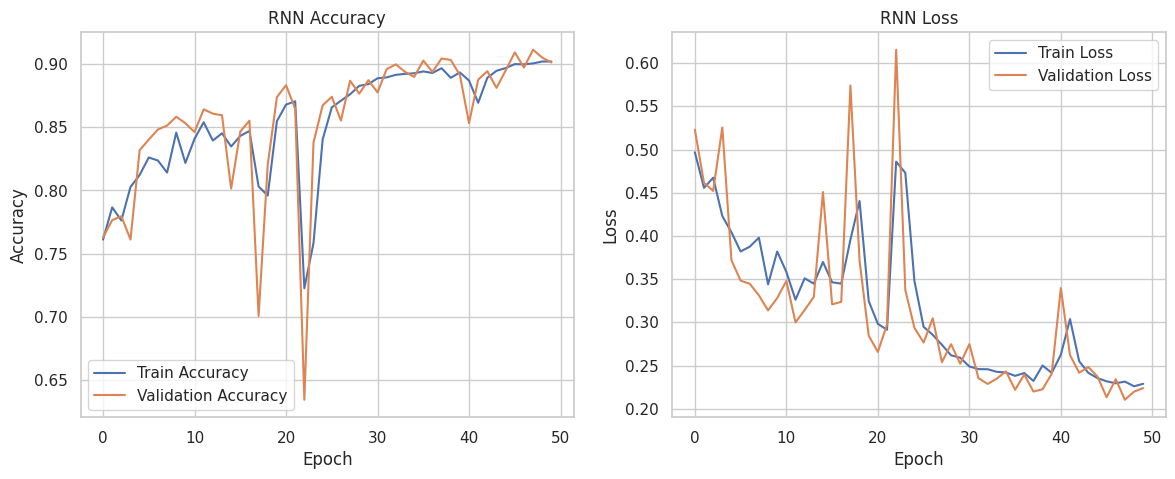

In [20]:
# Evaluate the RNN model
y_pred_proba_rnn = rnn_model.predict(X_test_rnn).flatten()
y_pred_rnn = (y_pred_proba_rnn > 0.5).astype(int)

evaluate_model(y_test, y_pred_rnn, y_pred_proba_rnn, "RNN")
plot_training_history(rnn_history, "RNN")

Epoch 1/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.8987 - loss: 0.2310 - val_accuracy: 0.9046 - val_loss: 0.2238
Epoch 2/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.8952 - loss: 0.2377 - val_accuracy: 0.8849 - val_loss: 0.2674
Epoch 3/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9036 - loss: 0.2211 - val_accuracy: 0.9072 - val_loss: 0.2154
Epoch 4/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.9058 - loss: 0.2183 - val_accuracy: 0.9132 - val_loss: 0.2044
Epoch 5/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.8998 - loss: 0.2307 - val_accuracy: 0.9088 - val_loss: 0.2134
Epoch 6/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.9077 - loss: 0.2123 - val_accuracy: 0.8888 - val_loss: 0.2437
Epoch 7/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.9049 - loss: 0.2151 - val_accuracy: 0.9059 - val_loss: 0.2153
Epoch 8/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.9062 - loss: 

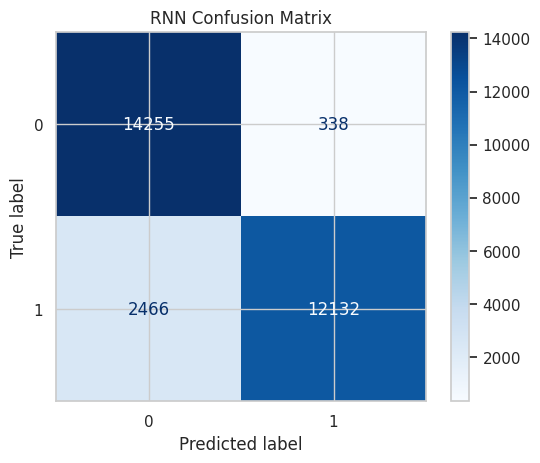

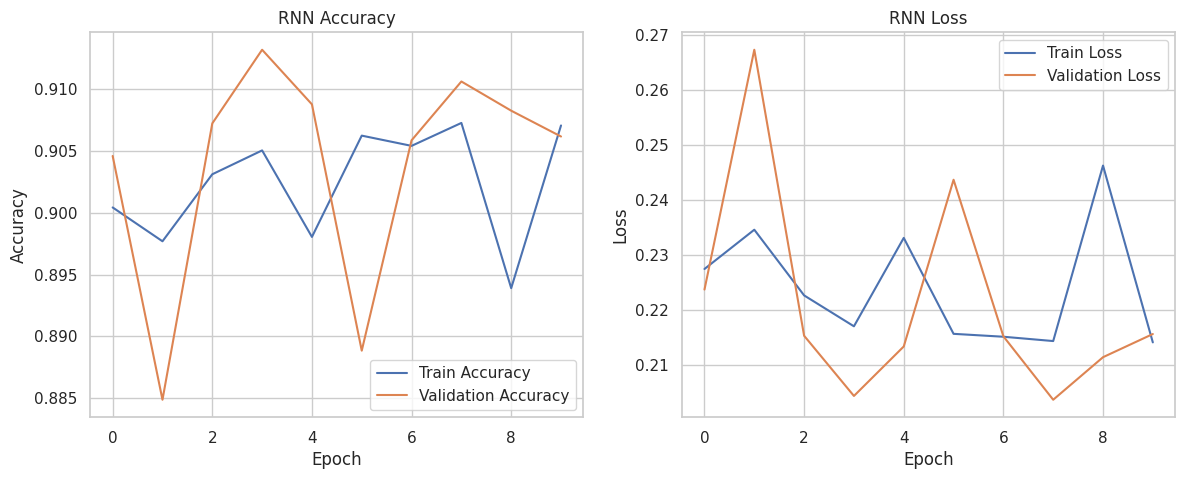

In [21]:
# Train the RNN model
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Predict on test set
y_pred_proba_rnn = rnn_model.predict(X_test_rnn).flatten()
y_pred_rnn = (y_pred_proba_rnn > 0.5).astype(int)

# Evaluate RNN model
evaluate_model(y_test, y_pred_rnn, y_pred_proba_rnn, "RNN")

# Plot training and validation history
plot_training_history(rnn_history, "RNN")

Epoch 1/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9194 - loss: 0.1949 - val_accuracy: 0.9160 - val_loss: 0.1985
Epoch 2/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9203 - loss: 0.1928 - val_accuracy: 0.9167 - val_loss: 0.1972
Epoch 3/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9210 - loss: 0.1901 - val_accuracy: 0.9192 - val_loss: 0.1917
Epoch 4/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9200 - loss: 0.1936 - val_accuracy: 0.9081 - val_loss: 0.2092
Epoch 5/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9183 - loss: 0.1953 - val_accuracy: 0.9157 - val_loss: 0.1934
Epoch 6/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9186 - loss: 0.1916 - val_accuracy: 0.9196 - val_loss: 0.1935
Epoch 7/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9202 - loss: 0.1927 - val_accuracy: 0.9197 - val_loss: 0.1933
Epoch 8/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9217 - loss: 0

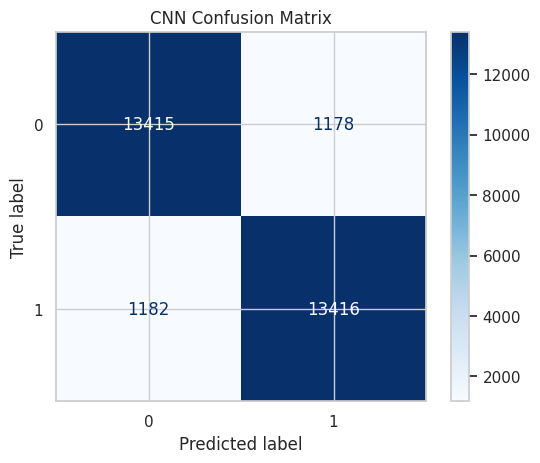

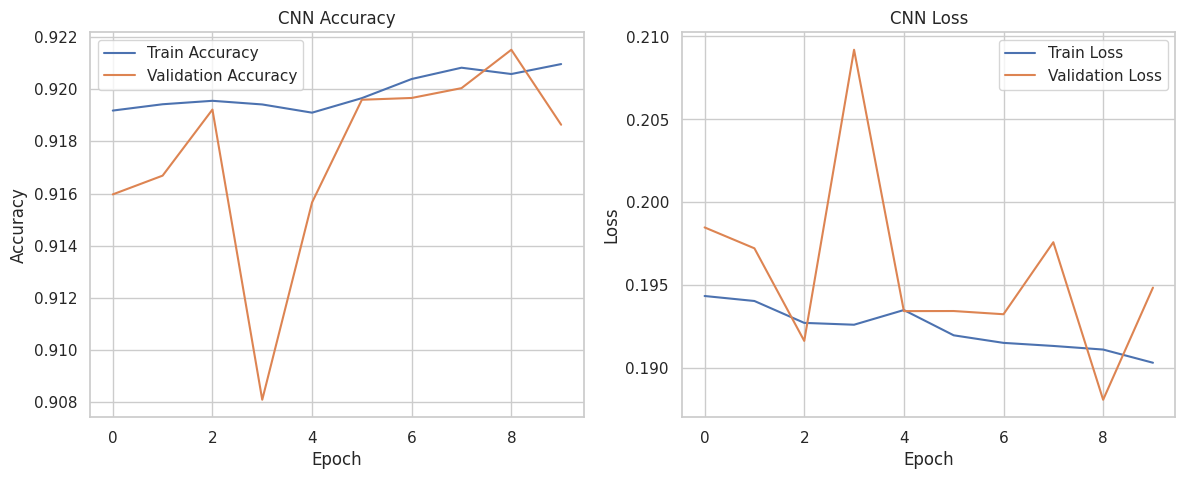

In [22]:
# Train the CNN model
cnn_history = cnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Predict on test set
y_pred_proba_cnn = cnn_model.predict(X_test_rnn).flatten()
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

# Evaluate CNN model
evaluate_model(y_test, y_pred_cnn, y_pred_proba_cnn, "CNN")

# Plot training and validation history
plot_training_history(cnn_history, "CNN")

Epoch 1/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - accuracy: 0.7504 - loss: 0.5178 - val_accuracy: 0.7670 - val_loss: 0.4805
Epoch 2/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 80s 19ms/step - accuracy: 0.7698 - loss: 0.4774 - val_accuracy: 0.7568 - val_loss: 0.5006
Epoch 3/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 76s 18ms/step - accuracy: 0.7756 - loss: 0.4735 - val_accuracy: 0.7890 - val_loss: 0.4453
Epoch 4/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - accuracy: 0.8085 - loss: 0.4131 - val_accuracy: 0.8372 - val_loss: 0.3463
Epoch 5/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 77s 18ms/step - accuracy: 0.8429 - loss: 0.3401 - val_accuracy: 0.8336 - val_loss: 0.3435
Epoch 6/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.8583 - loss: 0.3179 - val_accuracy: 0.7700 - val_loss: 0.4706
Epoch 7/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.7867 - loss: 0.4421 - val_accuracy: 0.8398 - val_loss: 0.3477
Epoch 8/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 77s 18ms/step - accuracy: 0.8189 -

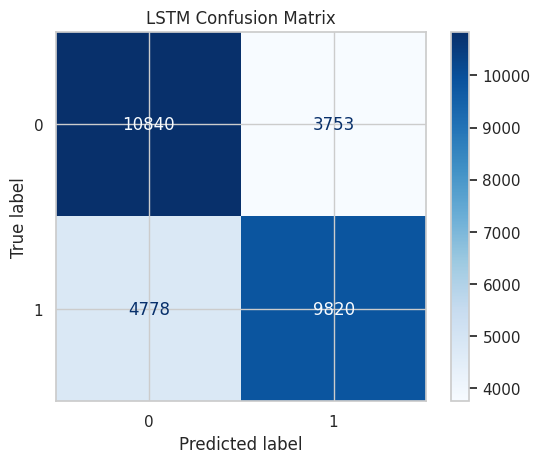

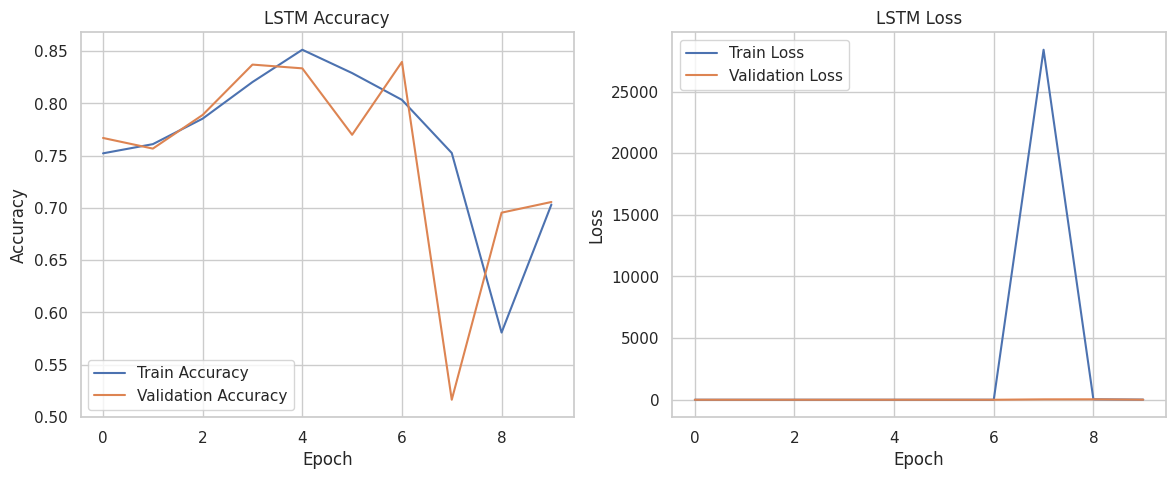

In [23]:
# Train the LSTM model
lstm_history = lstm_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32,
                              validation_data=(X_val_rnn, y_val), verbose=1)

# Predict on test set
y_pred_proba_lstm = lstm_model.predict(X_test_rnn).flatten()
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

# Evaluate LSTM model
evaluate_model(y_test, y_pred_lstm, y_pred_proba_lstm, "LSTM")

# Plot training and validation history
plot_training_history(lstm_history, "LSTM")

Epoch 1/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 106s 25ms/step - accuracy: 0.8787 - loss: 0.2688 - val_accuracy: 0.8804 - val_loss: 0.2676
Epoch 2/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 104s 24ms/step - accuracy: 0.8943 - loss: 0.2376 - val_accuracy: 0.8994 - val_loss: 0.2219
Epoch 3/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 142s 24ms/step - accuracy: 0.9064 - loss: 0.2110 - val_accuracy: 0.9090 - val_loss: 0.2037
Epoch 4/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 140s 24ms/step - accuracy: 0.9109 - loss: 0.2020 - val_accuracy: 0.9104 - val_loss: 0.2013
Epoch 5/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 139s 23ms/step - accuracy: 0.9115 - loss: 0.2002 - val_accuracy: 0.9011 - val_loss: 0.2152
Epoch 6/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 147s 25ms/step - accuracy: 0.8932 - loss: 0.2308 - val_accuracy: 0.6305 - val_loss: 0.6076
Epoch 7/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 143s 25ms/step - accuracy: 0.6991 - loss: 0.5433 - val_accuracy: 0.8296 - val_loss: 0.3545
Epoch 8/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 141s 24ms/step - accuracy: 

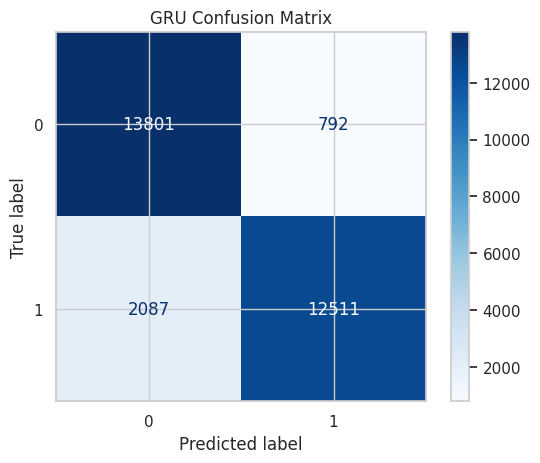

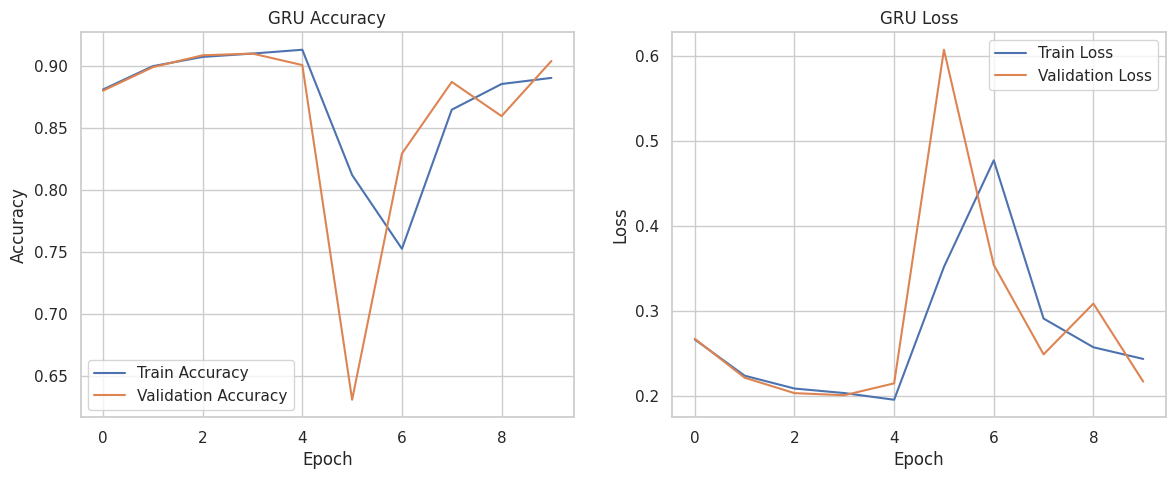

In [24]:
# Train the GRU model
gru_history = gru_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Predict on test set
y_pred_proba_gru = gru_model.predict(X_test_rnn).flatten()
y_pred_gru = (y_pred_proba_gru > 0.5).astype(int)

# Evaluate GRU model
evaluate_model(y_test, y_pred_gru, y_pred_proba_gru, "GRU")

# Plot training and validation history
plot_training_history(gru_history, "GRU")
